In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Look at the data

In [3]:
trump_path = Path('data/mrtrump')
trump_path.ls()

[PosixPath('data/mrtrump/MrTrumpSpeeches.csv'),
 PosixPath('data/mrtrump/models'),
 PosixPath('data/mrtrump/data_lm_factbase.pkl'),
 PosixPath('data/mrtrump/MrTrumpSpeeches_preview.csv'),
 PosixPath('data/mrtrump/data_lm.pkl'),
 PosixPath('data/mrtrump/models.bak'),
 PosixPath('data/mrtrump/factbase.csv')]

In [4]:
df = pd.read_csv(trump_path/'factbase.csv')
df.head()

,Unnamed: 0,transcript
0,0,"Oh, thank you very much. Thank you very much. ..."
1,1,"Thank you very much, El Paso. Thank you very m..."
2,2,"Madam Speaker, Mr. Vice President, Members of ..."
3,3,That's such a great song. We should just let i...
4,4,"My fellow Americans. Tonight, I am speaking to..."


In [5]:
df['transcript'][0]

'Oh, thank you very much. Thank you very much. And thank you very much also to a man named Matt Schlapp. What a job he\'s done. And to CPAC -- I actually started quite a while ago at CPAC, and came here -- probably made my first real political speech. And I enjoyed it so much that I came back for a second one, then a third. Then I said, what the hell, let\'s run for President. Right? But it\'s wonderful to be back with so many great patriots, old friends, and brave young conservatives. What a future you have. Our movement and our future in our country is unlimited. What we\'ve done together has never been done in the history maybe of beyond of country, maybe in the history of the world. They came from the mountains and the valleys and the cities. They came from all over. And what we did in 2016 -- the Election, we call it, with a capital "E" -- it\'s never been done before. And we\'re going to do it, I think, again in 2020, and the numbers are going to be even bigger. [Audience Chants 

Perhaps we should we remove tokens such as [applause], [music], etc. Let's roll with them for now, it could be fun.

## Read whole file to create a language model

In [6]:
dataframe = pd.read_csv(trump_path/'factbase.csv')

In [7]:
print(dataframe.shape)
print(dataframe.columns)
print(dataframe.head())

(493, 2)
Index(['Unnamed: 0', 'transcript'], dtype='object')
   Unnamed: 0                                         transcript
0           0  Oh, thank you very much. Thank you very much. ...
1           1  Thank you very much, El Paso. Thank you very m...
2           2  Madam Speaker, Mr. Vice President, Members of ...
3           3  That's such a great song. We should just let i...
4           4  My fellow Americans. Tonight, I am speaking to...


In [8]:
bs=50

In [9]:
data_lm = (TextList.from_df(dataframe, path=trump_path, cols='transcript')
              .random_split_by_pct(0.1)
              .label_for_lm()
               .databunch(bs=bs))

In [10]:
# Save for later
data_lm.save('data_lm_factbase.pkl')

In [11]:
data_lm.show_batch()

idx,text
0,"i enjoyed it so much that i came back for a second one , then a third . xxmaj then i said , what the hell , let 's run for xxmaj president . xxmaj right ? xxmaj but it 's wonderful to be back with so many great patriots , old friends , and brave young conservatives . xxmaj what a future you have . xxmaj our movement and"
1,"for all the wrong reasons , but i like xxmaj kentucky . i liked it . i had a good time in xxmaj cincinnati , xxmaj ohio . i learned a lot . i learned a lot in xxmaj cincinnati , xxmaj ohio , and i love xxmaj ohio . xxmaj maybe that 's why we won it by so much , remember ? xxmaj everything goes through xxmaj ohio"
2,"'m going to build the wall . xxmaj and it 's only one of many things that i promised . i mean , if you look at -- [ xxmaj applause ] -- i got you the biggest tax cut -- beyond the xxmaj ronald xxmaj reagan tax cuts . xxup anwr , getting rid of the individual mandate , the biggest cuts in regulations in the history of our"
3,"with xxmaj judge xxmaj kavanaugh , they stick together -- or the xxmaj russian hoax with the election . xxmaj they use that as an excuse , because xxmaj hillary xxmaj clinton lost . xxmaj next time , they 'll learn . xxmaj you 've got to go , and you 've got to campaign in xxmaj wisconsin . xxmaj you 've got to campaign harder in xxmaj pennsylvania ."
4,"and xxup xxunk -- you see the xxup ms-13 predators . xxmaj some people do n't like it when i use that name . xxmaj these are predators . [ xxmaj audience members calls out ] xxmaj only in xxmaj wisconsin , right . xxmaj only . xxmaj she 's screaming . xxmaj screaming . xxmaj she 's screaming . i wo n't say what you xxunk . [ xxmaj"


In [12]:
len(data_lm.vocab.itos)

14200

## Load pretrained language model

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
AWD_LSTM??

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02


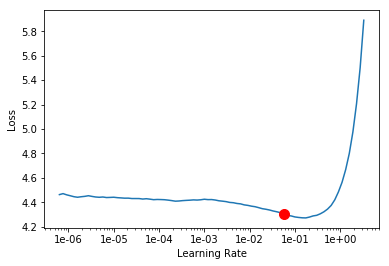

In [16]:
learn.recorder.plot()

Min numerical gradient: 5.75E-02


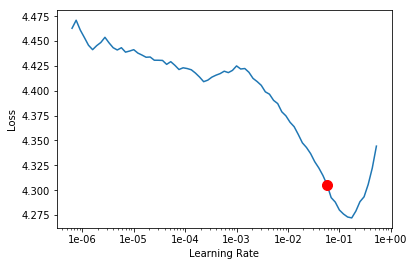

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,3.331311,3.154359,0.365432


In [19]:
learn.save('fit_head_factbase')

## Unfreeze to fine-tune

In [20]:
learn.unfreeze()

In [21]:
torch.cuda.empty_cache()

In [22]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,2.640940,2.622111,0.461781
2,2.416591,2.480331,0.497998
3,2.350334,2.425684,0.510910
4,2.247326,2.327184,0.526527
5,2.137615,2.388789,0.511832
6,2.041864,2.221417,0.541740
7,1.867689,2.071336,0.568557
8,1.654204,2.021322,0.578129
9,1.527899,1.988680,0.585818
10,1.375008,2.010836,0.583650


In [23]:
learn.save('fine_tuned_factbase')

In [24]:
learn.save_encoder('fine_tuned_encoder_factbase')

In [25]:
TEXT = 'We need to build a wall'
N_WORDS = 100
N_SENTENCES = 1

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We need to build a wall , do n't worry about it . i 'm not sure we have a wall , but we need it . It 's going to be a beautiful first . And i want to say , here , we are going to have a wall . We 're going to have a wall . [ Applause ] And we will build a wall . We have the wall . We have the best wall . We have the best wall . We have the best military in the world , we


In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We need to build a wall . We need the wall ! We need the wall ! We need the wall ! We need the wall ! We need the wall . We did n't have the wall . We do n't have a wall . We do n't have a wall , folks . We do n't have a wall . We have a wall . And if i did n't have the wall , i would n't have a wall like that . When we build a wall , we have to


In [28]:
TEXT = 'Hillary Clinton'
N_WORDS = 100
N_SENTENCES = 1

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Hillary Clinton is the most corrupt person ever to seek the office of the presidency . [ Applause ] She 's the one who created it with a rigged system . Now , in fact , the FBI , as many as these people -- can not be allowed to run for the presidency . [ Applause ] And then what happens is we see a very highly respected congressional record , and i want to thank Secretary John Podesta . And i want to thank Podesta for being here ,


In [30]:
def generate_phrase(seed, nwords=100):
    return learn.predict(seed, nwords, temperature=0.75)

In [31]:
generate_phrase('Steve Bannon')

"Steve Bannon , President Trump , i am here for Matt Schlapp by the way , who 's so here , i think , is going to be here . [ Applause ] If Matt Stands does not support our military , i 'd like to thank Matt Rosendale and his wife Matt . And i 'll tell you what , he loves this state , and i can tell you , he has been fantastic . He 's been an incredible leader . i want to thank you"

In [32]:
generate_phrase('Hillary Clinton')

"Hillary Clinton does not know that . She does n't know what she 's going to do . But Hillary Clinton 's policies in Iraq have cost less money in order to help those suffering and suffering in the Middle East . This will also be a total and complete disaster . Hillary Clinton is the candidate of yesterday . We 're the movement of the future . We are the movement of the future . The future belongs to you . It 's the future ."

In [33]:
generate_phrase('Make America great again')

'Make America great again . [ Applause ] Thank you . Thank you . Thank you . Thank you . Thank you . [ Applause ] Thank you very much . [ Applause ] Thank you . Thank you . Thank you . Thank you very much . Thank you very much , everybody . Great job . Great job . Thank you very much . Thank you . Thank you . Go home . [ Applause ] xxbos [ This was'

In [35]:
generate_phrase('Obama')

"Obama , Clinton , Clinton , Pence , Trump , Clinton , Pence , Girl , Dunford , Congresswoman All of the Democrats , i think they 're going to be very , very happy , but they 're going to be very happy . They 're going to be happy to be happy . You know , Bernie Sanders got a little bit of a endorsement . He got some care . He did n't know anything about it . [ Applause"